# Autoencoders

**Exercise objectives**
- Discover autoencoders
- Get a deeper understanding of CNNs

<hr>

🤔 There is a very particular architecture in Deep Learning called **`Autoencoders`**.


👉 Autoencoders are Neural Network architectures trained to return **outputs that are as similar as possible to the original inputs fed to them**. Why would we do that ?  

Before answering the question `why`, let's answer the question `how`.

***How does an autoencoder work ?***

There are two parts in an autoencoder:
1. an **`encoder`**
2. a **`decoder`**

1. In encoder, we will make the information flow through different dense layers with a decreasing number of neurons. It will create a **`bottleneck`** where the information is somewhat compressed.

2. In the decoder, we will try to create the original data based on the compressed data.

***Why is it powerful, useful ?***

If it works well, it means two important things:

* ✅ We can afford to **compress our dataset and use a compressed version of it when fitting another Neural Network** ! 

* ✅ The **information contained in the bottleneck** - i.e. the data compressed in a low-dimensional layer - **accurately captures the patterns of our dataset** and the autoencoder is able to decode the compressed information !

**Applications:**
- Image compression
- Denoising (cf. Google Pixel phones...)
- Image generation !


<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

## The MNIST Dataset

In this notebook, we will train an auto-encoder to work on 28x28 grey images from the MNIST dataset, available in Keras. Run the cells below

In [0]:
from tensorflow.keras.datasets import mnist

(images_train, labels_train), (images_test, labels_test) = mnist.load_data()
print(images_train.shape)
print(images_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [0]:
# Add a channels for the colors and normalize data
X_train = images_train.reshape((60000, 28, 28, 1)) / 255.
X_test = images_test.reshape((10000, 28, 28, 1)) / 255.

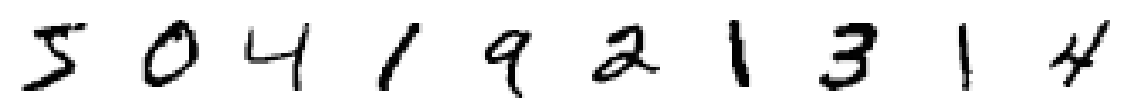

In [0]:
# Plot some images
import matplotlib.pyplot as plt

f, axs = plt.subplots(1, 10, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.axis('off')
    ax.imshow(X_train[i].reshape(28, 28), cmap='Greys')
    
plt.show()

## The encoder

First, we will build the "Encoder" part for you (in blue in the network picture above)

💡 Notice how similar it looks compared to a Convolutional Classifier:
* with `latent_dimension` labels
* the `tanh` activation function inf the final dense layer

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Conv2D(8, (2,2), input_shape=(28, 28, 1), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(16, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(32, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))     

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

❓ **Question** ❓ Build your encoder with  `latent_dimension=2` and look at the number of parameters.

In [0]:
encoder = build_encoder(2)
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 27, 27, 8)         40        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 16)        528       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

## Decoder

It's your turn to build the decoder this time!

We need to build a **`reversed CNN`** that 
* takes a dense layer as input,
* and output an image of shape `(28,28,1)` similar to our MNIST images. 

🤓 For this purpose, we will use a new layer called <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">**`Conv2DTranspose`**</a>.
    
The name of this layer speaks for itself: it performs the opposite of a convolution operation!

💡 Hint: We will follow this strategy :
* Start by reshaping the Dense Input Layer into an Image of shape `(7,7,..)`
* Then apply the `Conv2DTranspose` operation with `strides=2` to double the output shape to `(14,14,..)` 
* then add another Conv2DTranpose layer on top of the first one to make it `(28,28,1)`.

❓ **Question** ❓ Define a **`decoding architecture`** in the method below as follows:
- a `Dense` layer with:
    - $7 \times 7 \times 8$ neurons, 
    - input_shape = `(latent_dimension,)`
    - `tanh` activation function. 
- a `Reshape` layer that reshapes to `(7, 7, 8)` tensors
- a `Conv2DTranspose` with:
    - `8` filters, 
    - `(2,2)` kernels, 
    - strides of `2`, 
    - padding `same` 
    - `relu` activation function
- a second Conv2DTranspose layer with:
    - `1` filter,
    - `(2,2)` kernels,
    - strides of `2`,
    - padding `same`,
    - `relu` activation function

In [0]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

def build_decoder(latent_dimension):
    # $CHALLENGIFY_BEGIN
    decoder = Sequential()
    
    decoder.add(Dense(7*7*8, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((7, 7, 8)))  # no batch axis here
    decoder.add(Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))

    decoder.add(Conv2DTranspose(1, (2, 2), strides=2, padding='same', activation='relu'))
    return decoder
    # $CHALLENGIFY_END

❓ **Question** ❓ Build your decoder with `latent_dimension=2` and check that it outputs images of same shape than the encoder input

In [0]:
decoder = build_decoder(2)
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 392)               1176      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         264       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         33        
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


## Auto-Encoder

🎉 We can now concatenate both **`the encoder and the decoder`** thanks to the **`Model`** class in Keras, using the **`functionalAPI`**.

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_autoencoder(encoder, decoder):
    inp = Input((28, 28,1))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

❓ **Questions** ❓ 

* Try to understand syntax above 👆 
* Build your autoencoder
* Have a look at the number of parameters

In [0]:
autoencoder = build_autoencoder(encoder, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 2906      
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         1473      
Total params: 4,379
Trainable params: 4,379
Non-trainable params: 0
_________________________________________________________________


❓ **Question** ❓ Define a method which compiles your model. Pick an appropriate loss.

Think carefully: 
🤔 On which mathematical object are we going to `compare predictions and the ground truths` for the computation of the loss function and the metrics?


<details>
    <summary>🆘 Answer 🆘</summary>

It should compare two images (Black and White in our case), pixel-by-pixel!
    
The MSE loss seems  to be an appropriate loss function for pixel-by-pixel error minimization.
</details>

In [0]:
def compile_autoencoder(autoencoder):
    # $CHALLENGIFY_BEGIN
    autoencoder.compile(loss='mse',
                  optimizer='adam')
    # $CHALLENGIFY_END

❓ **Question** ❓  Compile your model and fit it with  `batch_size = 32` and `epochs=20`. What is the label `y_train` in this case?

**Note:** Don't waste your time fighting overfitting in this challenge, you will have time to care about his during the project weeks :)

In [0]:
compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32)

2021-08-11 16:27:16.973063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0597
Epoch 2/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0538
Epoch 3/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0526
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0521
Epoch 5/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0517
Epoch 6/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0514
Epoch 7/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0512
Epoch 8/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0510
Epoch 9/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0509
Epoch 10/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0508
Epoch 11/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0506
Epoch 12/20
1875/1875 [==============================] - 12s 6ms/step - lo

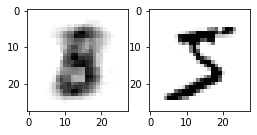

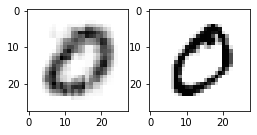

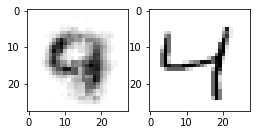

In [0]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=100)# you can now display an image to see it is reconstructed well

for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(prediction[i].reshape(28,28), cmap='Greys')
    ax2.imshow(X_train[i].reshape(28,28), cmap='Greys')
    plt.show()

❓ **Question** ❓ Using only the encoder part of the network, encode your dataset and save it under `X_encoded` . 

Each image is now represented by two values (that correspond to the dimension of the latent space, of the bottleneck; aka the `latent_dimension`. 

In [0]:
##############
### Answer ###
##############

X_encoded = encoder.predict(X_train, verbose=1)

1875/1875 [==============================] - 3s 2ms/step


🤔 Where are we after running the encoder ?

* Each image was compressed in a 2D space. 
* Each of these handwritten digit have to a given label, between 0 and 9  

❓ **Question** ❓ 

Scatterplot the encoded data (only a small fraction of the encoded dataset for visibility purposes...)
- Each point of the scatter plot  corresponds to an encoded image
- Color the dots according to their respective labels (digit representation).
    - For instance, all the "4"s should be represented by a color on this scatter plot, 
    - While the "5" should be represented by another color.

What do you remark on this plot? 

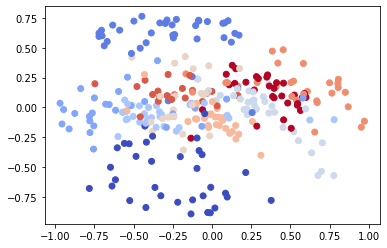

In [0]:
import seaborn as sns
plt.scatter(x= X_encoded[:300, 0], y=X_encoded[:300, 1], c=labels_train[:300], cmap='coolwarm');

# 5. Application: Image denoising


❓ **Questions** ❓ 

* Let's add some noise to the input data. 
* Run the following code
* Plot some handwritten digits and their noisy versions

In [0]:
import numpy as np

noise_factor = 0.5

X_train_noisy = X_train + noise_factor * np.random.normal(0., 1., size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(0., 1., size=X_test.shape)

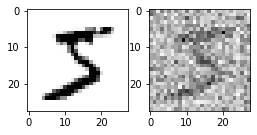

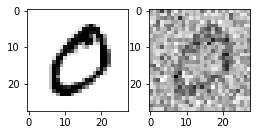

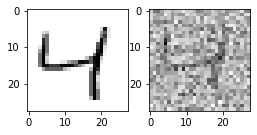

In [0]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(X_train[i].reshape(28,28), cmap='Greys')
    ax2.imshow(X_train_noisy[i].reshape(28,28), cmap='Greys')
    plt.show()

❓ **Question** ❓ 

* Reinitialize your autoencoder (with a latent space of 2) 
* Train it again, this time using the noisy train dataset instead of the normal train dataset
    * *Keep `batch_size = 32` and `epochs=5`*
* What do you expect if you run the autoencoder on the noisy data instead of the original data in terms of performance ?

In [0]:
encoder = build_encoder(2)
decoder = build_decoder(2)
autoencoder = build_autoencoder(encoder, decoder)
compile_autoencoder(autoencoder)

history_denoising = autoencoder.fit(X_train_noisy, X_train, epochs=20, batch_size=32)

Epoch 1/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0628
Epoch 2/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0557
Epoch 3/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0542
Epoch 4/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0537
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0533
Epoch 6/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0529
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0526
Epoch 8/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0524
Epoch 9/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0522
Epoch 10/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0521
Epoch 11/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0521
Epoch 12/20
1875/1875 [==============================] - 12s 6ms/step - lo

❓ **Question** ❓ For some noisy test images, predict the denoised images and plot the results side by side...

313/313 [==============================] - 1s 2ms/step


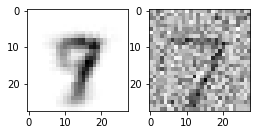

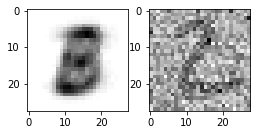

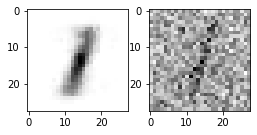

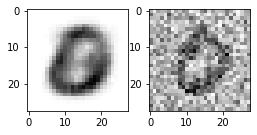

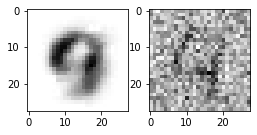

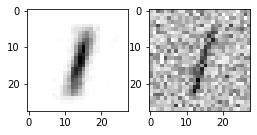

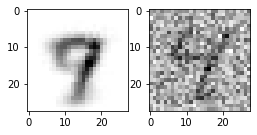

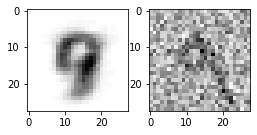

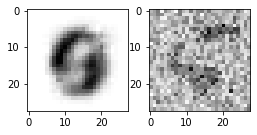

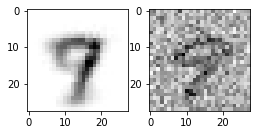

In [0]:
prediction = autoencoder.predict(X_test_noisy, verbose=1)

for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(prediction[i].reshape(28,28), cmap='Greys')
    ax2.imshow(X_test_noisy[i].reshape(28,28), cmap='Greys')
    plt.show()

❓ **Question** ❓ 

👉 Now, try to evaluate which **`latent_dimension`** is the most suitable in order to have **`the best image reconstruction preprocess`** 

👉 that is to ask: `How to remove as much noise as possible in the noisy dataset using the latent dimension?`

In [0]:
# YOUR ANSWER HERE

In [0]:
latent_dimensions = list(range(2,20,3))

test_errors = []
for latent_dimension in latent_dimensions:
    print(" ")
    print("-"*80)
    print(f"Running the autoencoder with latent_dimension = {latent_dimension}")
    print("-"*80)    
    encoder = build_encoder(latent_dimension=latent_dimension)
    decoder = build_decoder(latent_dimension=latent_dimension)
    autoencoder = build_autoencoder(encoder, decoder)
    compile_autoencoder(autoencoder)
    autoencoder.fit(X_train, X_train, epochs=20, batch_size=32)
    error = autoencoder.evaluate(X_test, X_test)
    test_errors.append(error)


 
--------------------------------------------------------------------------------
Running the autoencoder with latent_dimension = 2
--------------------------------------------------------------------------------
Epoch 1/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0602
Epoch 2/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0542
Epoch 3/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0529
Epoch 4/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0522
Epoch 5/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0518
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0514
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0511
Epoch 8/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0509
Epoch 9/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0507
Epoch 10/20
1875/1875 [=======

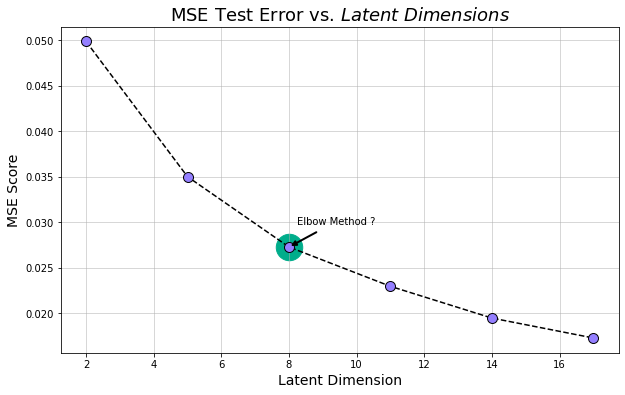

In [0]:
import matplotlib.pyplot as plt

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(latent_dimensions, test_errors,color='black', linestyle='dashed', marker='o',markerfacecolor='#947FFF', markersize=10)
    # more
    ax.set_title('MSE Test Error vs. $Latent$ $Dimensions$', fontsize = 18)
    ax.set_xlabel('Latent Dimension', fontsize = 14)
    ax.set_ylabel('MSE Score', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    
    # focusing
    ax.scatter(8,test_errors[2],c='#00ad8b',s=700)
    
    # annotate
    ax.annotate("Elbow Method ?", 
               xy=(8,test_errors[2]),
                xytext=(8+0.25,test_errors[2]+0.0025), 
                arrowprops=dict(arrowstyle='-|>',
                                fc="k",
                                ec="k",
                                lw=2),
                bbox=dict(pad=5, facecolor="none", edgecolor="none")
               )
    
    #ax.annotate("Best K", 
          #  xy=(11,score[11-1]),
          #  xytext=(11+0.25,score[11-1]-0.025), 
          #  arrowprops=dict(arrowstyle='-|>',
            #                fc="k",
            #                ec="k",
           #                 lw=2),
           # bbox=dict(pad=5, facecolor="none", edgecolor="none")
           #)

    # spines
    
    
    plt.show();
